In [1]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
torch.cuda.set_device(0)  # For GPU 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


1
NVIDIA GeForce GTX 1650
Using device: cuda


In [2]:
pip install torch torchaudio matplotlib pandas scikit-learn tqdm librosa

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\DHRUV\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import librosa

# Set the path to your dataset
DATA_PATH = r"D:\MLgunshot\Gunshot audio dataset"

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Function to create mel spectrogram
def create_mel_spectrogram(audio_path, n_mels=128, n_fft=2048, hop_length=512):
    waveform, sample_rate = torchaudio.load(audio_path)
    waveform = waveform.mean(dim=0)  # Convert stereo to mono if necessary
    
    # Resample if the sample rate is not 44100 Hz
    if sample_rate != 44100:
        resampler = torchaudio.transforms.Resample(sample_rate, 44100)
        waveform = resampler(waveform)
    
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=44100,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )(waveform)
    
    mel_spectrogram = librosa.power_to_db(mel_spectrogram.numpy(), ref=np.max)
    return torch.tensor(mel_spectrogram)

In [6]:

class GunShotDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        audio_path, label = self.data.iloc[idx]
        mel_spec = create_mel_spectrogram(audio_path)
        
        # Add a channel dimension (C=1) to the mel spectrogram
        mel_spec = mel_spec.unsqueeze(0)  # Shape: [1, n_mels, time_steps]
        
        if self.transform:
            mel_spec = self.transform(mel_spec)
        return mel_spec, label


In [7]:
# CNN Model
class GunShotCNN(nn.Module):
    def __init__(self, num_classes):
        super(GunShotCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
# Prepare the data
data = []
class_names = os.listdir(DATA_PATH)
for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(DATA_PATH, class_name)
    for audio_file in os.listdir(class_path):
        if audio_file.endswith('.wav'):
            audio_path = os.path.join(class_path, audio_file)
            data.append((audio_path, class_idx))

df = pd.DataFrame(data, columns=['audio_path', 'label'])

# Split the data
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


In [48]:
def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_samples = 0

    for inputs, _ in loader:
        # Reshape the batch (batch_size, channels, height, width)
        batch_samples = inputs.size(0)
        inputs = inputs.view(batch_samples, inputs.size(1), -1)
        mean += inputs.mean(2).sum(0)
        std += inputs.std(2).sum(0)
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples
    return mean, std

# Use a DataLoader to load data without transforms (except resize)
simple_transform = transforms.Compose([transforms.Resize((128, 128))])
simple_dataset = GunShotDataset(train_df, transform=simple_transform)
simple_loader = DataLoader(simple_dataset, batch_size=32, shuffle=True, num_workers=0)

mean, std = calculate_mean_std(simple_loader)

print(f'Mean: {mean}')
print(f'Standard Deviation: {std}')


Mean: tensor([-36.5228])
Standard Deviation: tensor([16.4053])


In [9]:
# Prepare datasets and dataloaders
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=[-27.43], std=[14.988])  # Adjust these values based on your data
])

train_dataset = GunShotDataset(train_df, transform=transform)
test_dataset = GunShotDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Initialize the model, loss function, and optimizer
model = GunShotCNN(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [10]:
# Print data information
print(f"Total number of samples: {len(df)}")
print(f"Number of classes: {len(class_names)}")
print("Class distribution:")
print(df['label'].value_counts().sort_index())

Total number of samples: 851
Number of classes: 9
Class distribution:
label
0     98
1     72
2    100
3    100
4     99
5    100
6    100
7    100
8     82
Name: count, dtype: int64


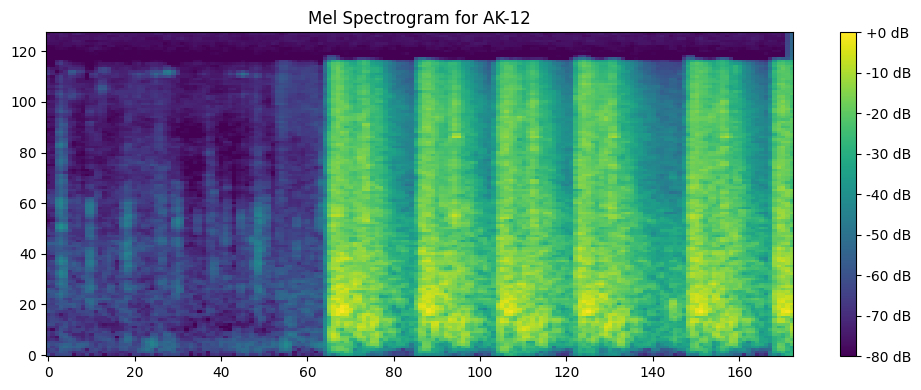

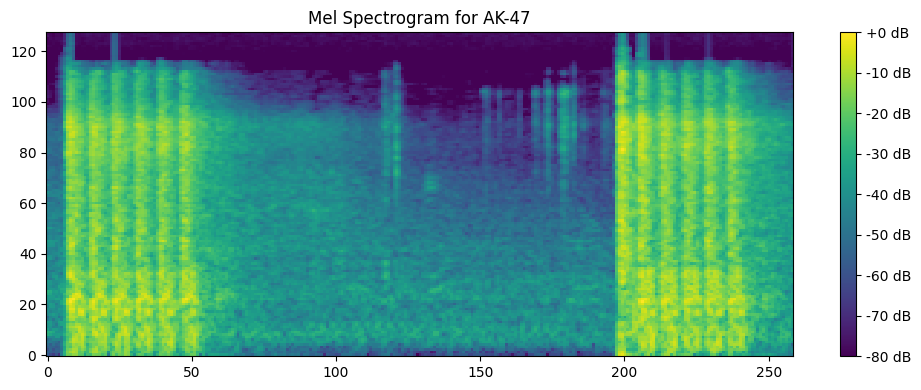

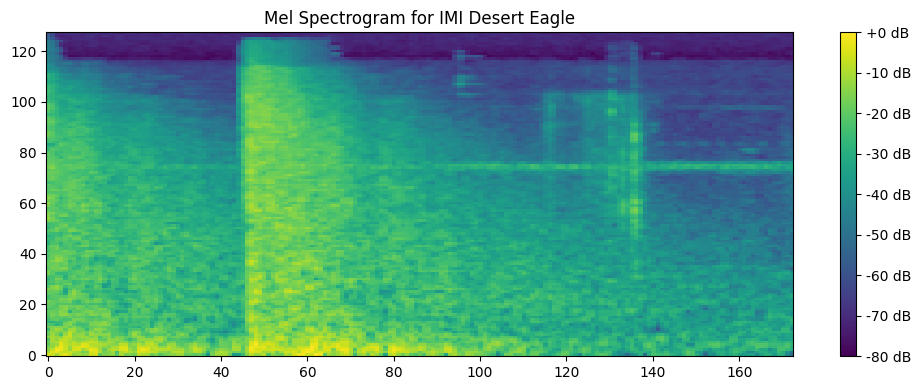

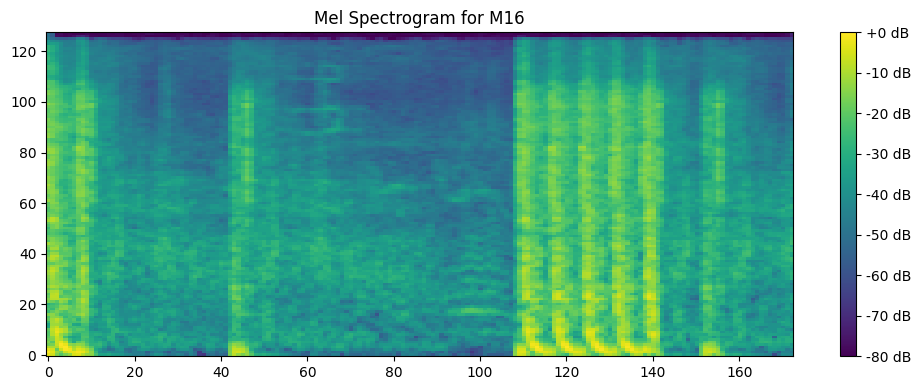

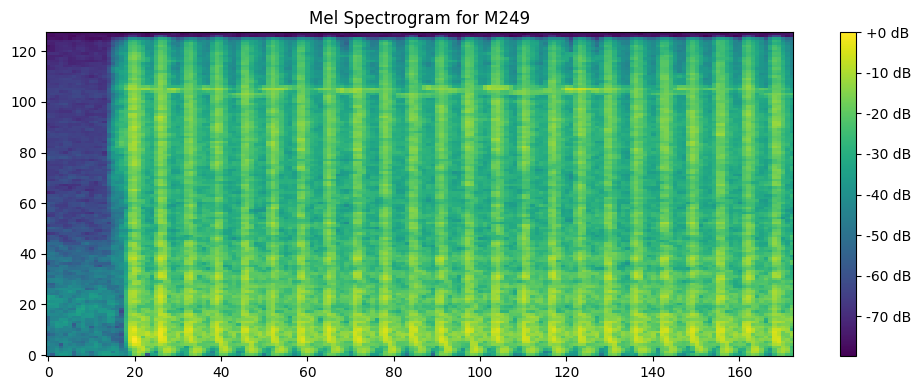

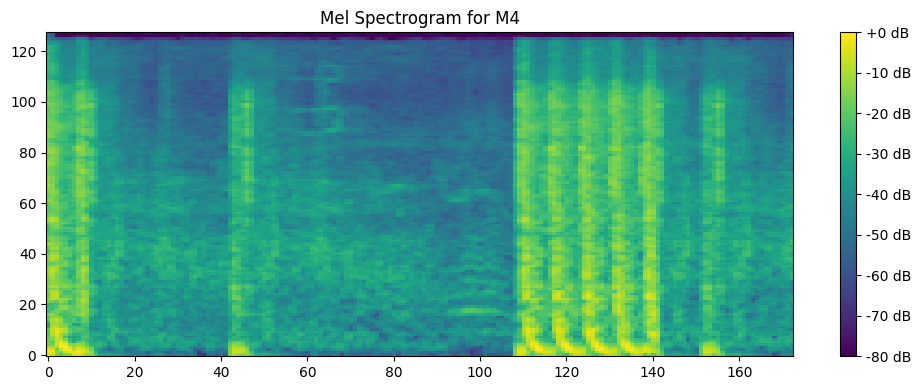

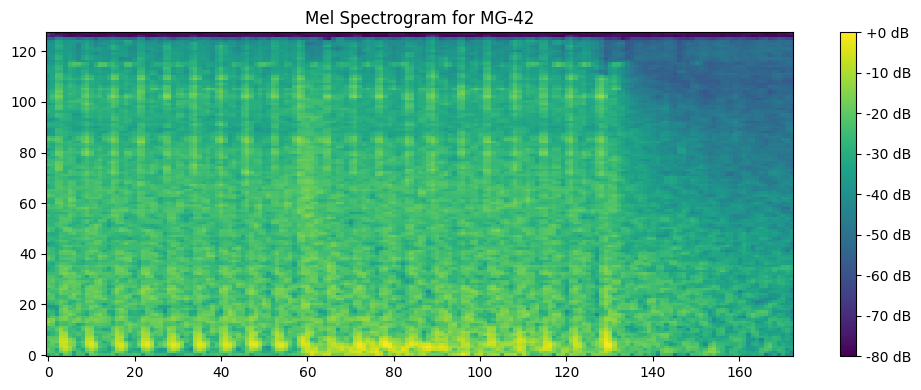

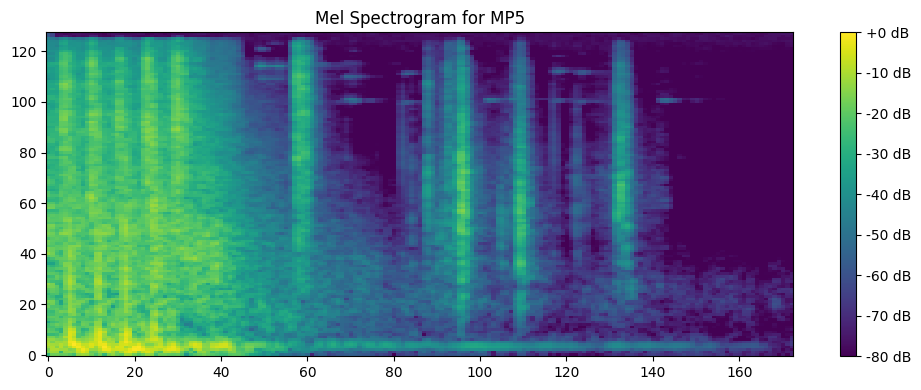

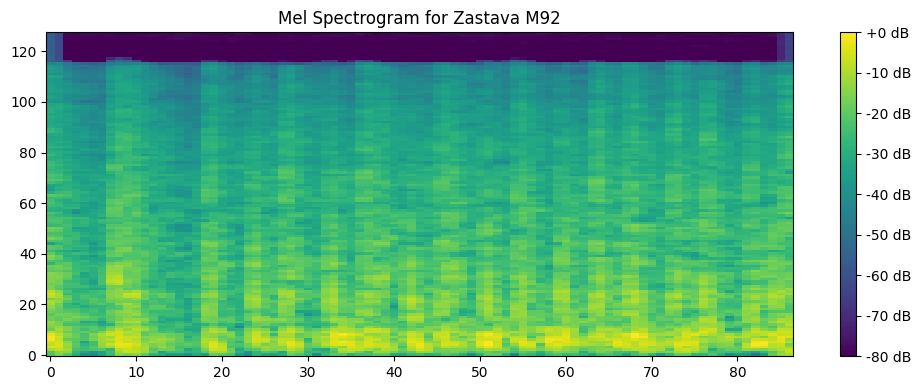

In [11]:
# Verify mel spectrogram generation
def plot_mel_spectrogram(mel_spec, title):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec.squeeze().numpy(), aspect='auto', origin='lower', interpolation='nearest')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Generate and plot a mel spectrogram for a sample from each class
for class_idx, class_name in enumerate(class_names):
    sample = df[df['label'] == class_idx].iloc[0]
    mel_spec = create_mel_spectrogram(sample['audio_path'])
    plot_mel_spectrogram(mel_spec, f"Mel Spectrogram for {class_name}")

Batch 1:
Input shape: torch.Size([32, 1, 128, 128])
Labels shape: torch.Size([32])
Labels: tensor([7, 2, 2, 1, 7, 1, 8, 6, 5, 6, 8, 5, 4, 6, 0, 7, 0, 3, 1, 4, 3, 7, 1, 3,
        3, 0, 0, 5, 7, 6, 4, 0])


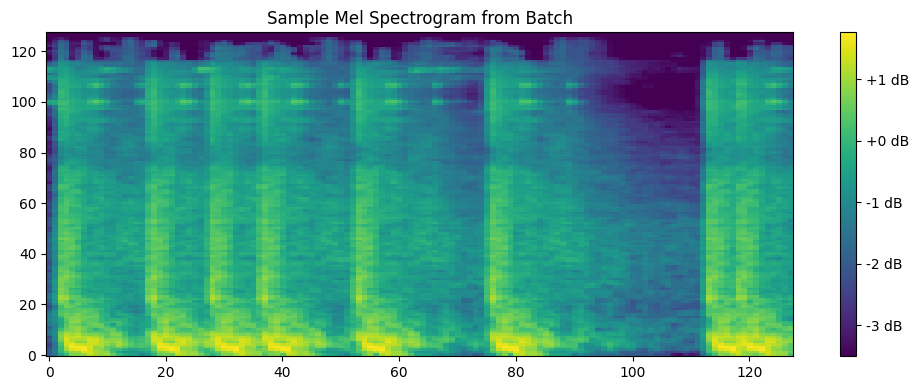

Data preparation and mel spectrogram generation verified successfully!


In [12]:
# Verify data loader
for batch_idx, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Input shape: {inputs.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels}")
    
    # Plot the first mel spectrogram in the batch
    plot_mel_spectrogram(inputs[0], "Sample Mel Spectrogram from Batch")
    
    if batch_idx == 0:  # Only check the first batch
        break

print("Data preparation and mel spectrogram generation verified successfully!")

Epoch 50/50: 100%|██████████| 22/22 [00:06<00:00,  3.61it/s, loss=0.152, accuracy=89.4] 


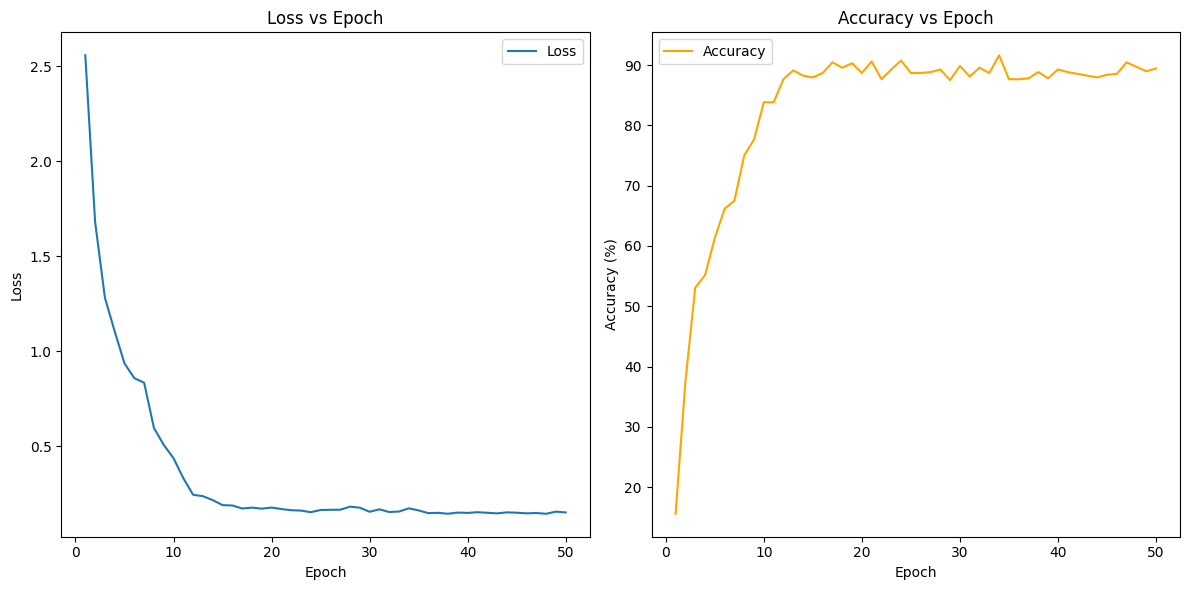

In [14]:
import matplotlib.pyplot as plt

# Initialize lists to store loss and accuracy values
losses = []
accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({'loss': running_loss/len(train_loader), 'accuracy': 100.*correct/total})
    
    # Store loss and accuracy for this epoch
    losses.append(running_loss / len(train_loader))
    accuracies.append(100. * correct / total)

# Plot Loss vs Accuracy
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [49]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Evaluating'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f'Test Accuracy: {100.*correct/total:.2f}%')

# Save the model
torch.save(model.state_dict(), 'gunshot_classifier.pth')
print("Model saved as 'gunshot_classifier.pth'")

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Test Accuracy: 69.01%
Model saved as 'gunshot_classifier.pth'


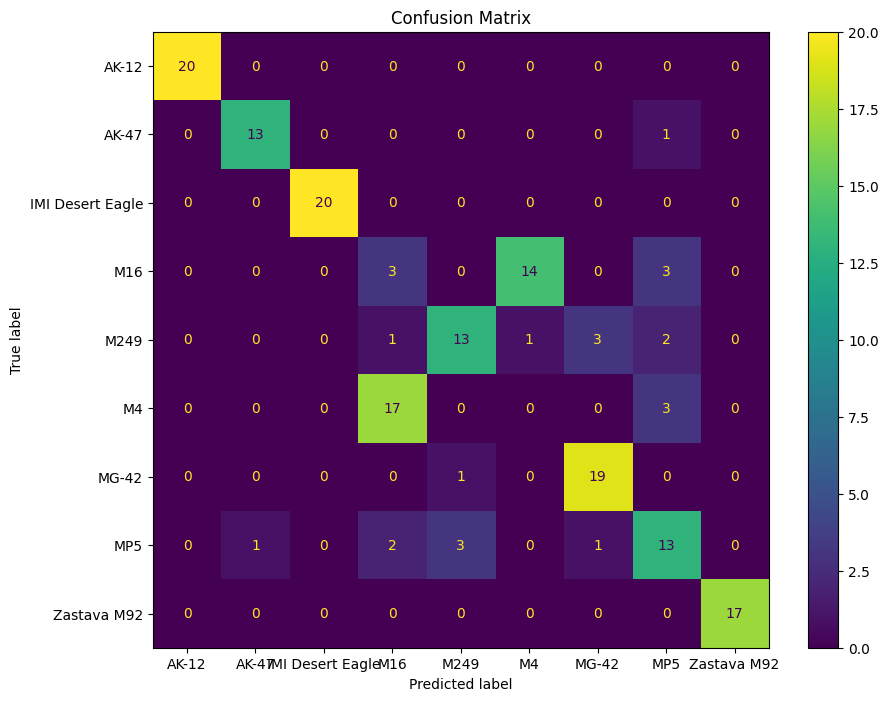

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Function to compute confusion matrix
def compute_confusion_matrix(loader, model, device):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    return confusion_matrix(all_labels, all_preds)

# Compute confusion matrix
cm = compute_confusion_matrix(test_loader, model, device)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='viridis', colorbar=True)
plt.title('Confusion Matrix')
plt.show()


Confusion Matrix Shape: (8, 8)
Number of Labels: 8
Combined Class Names: ['AK-12', 'AK-47', 'IMI Desert Eagle', 'AR-15', 'M249', 'MG-42', 'MP5', 'Zastava M92']


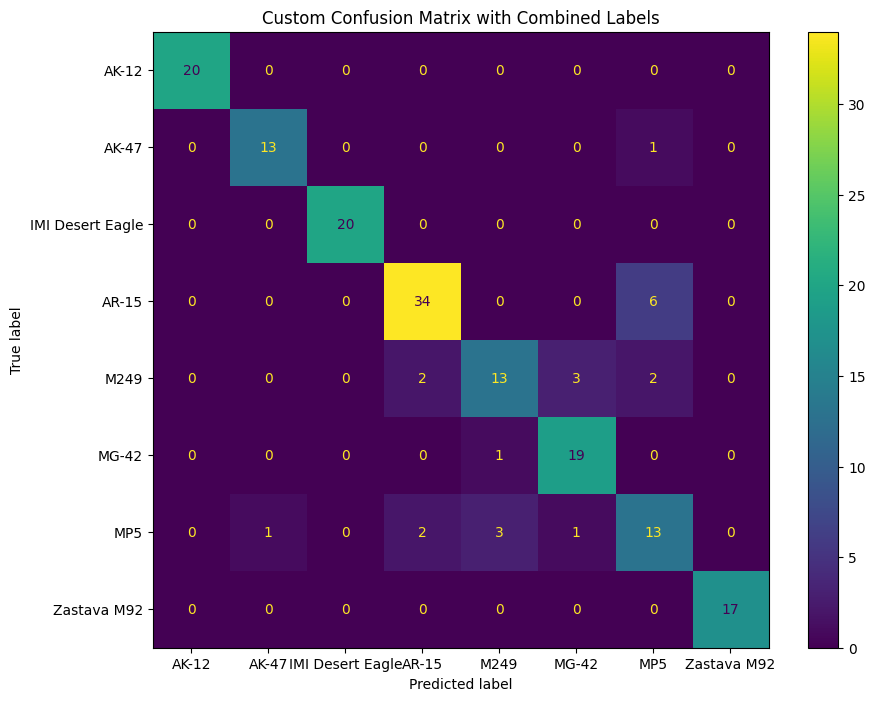

In [46]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def combine_labels(cm, combine_indices, original_class_names):
    num_classes = cm.shape[0]
    new_num_classes = num_classes - sum(len(group) - 1 for group in combine_indices)
    combined_cm = np.zeros((new_num_classes, new_num_classes), dtype=int)
    
    # Create a mapping from old indices to new indices
    index_map = {}
    new_index = 0
    new_class_names = []

    for i in range(num_classes):
        mapped = False
        for group in combine_indices:
            if i in group:
                if group[0] not in index_map:
                    index_map[group[0]] = new_index
                    new_class_names.append("AR-15")  # Use the new combined name
                    new_index += 1
                index_map[i] = index_map[group[0]]
                mapped = True
                break
        if not mapped:
            index_map[i] = new_index
            new_class_names.append(original_class_names[i])
            new_index += 1
    
    # Accumulate values in the combined confusion matrix
    for i in range(num_classes):
        for j in range(num_classes):
            new_i = index_map[i]
            new_j = index_map[j]
            combined_cm[new_i, new_j] += cm[i, j]
    
    return combined_cm, new_class_names

# Assuming you have your original confusion matrix 'cm' and original class names
original_class_names = ['AK-12', 'AK-47', 'IMI Desert Eagle', 'M16', 'M249', 'M4', 'MG-42', 'MP5', 'Zastava M92']

# Define indices to combine (3 and 5 for AR-15, which correspond to M16 and M4)
combine_indices = [(3, 5)]

# Compute the combined confusion matrix
cm_combined, combined_class_names = combine_labels(cm, combine_indices, original_class_names)

# Print matrix size and class names length for verification
print(f"Confusion Matrix Shape: {cm_combined.shape}")
print(f"Number of Labels: {len(combined_class_names)}")
print(f"Combined Class Names: {combined_class_names}")

# Plot the combined confusion matrix
if cm_combined.shape[0] == len(combined_class_names):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_combined, display_labels=combined_class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='viridis', colorbar=True)
    plt.title('Custom Confusion Matrix with Combined Labels')
    plt.show()
else:
    print("Error: Number of class names does not match the confusion matrix dimensions.")